In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
from string import punctuation
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer


from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,plot_confusion_matrix
from sklearn.model_selection import train_test_split
import collections

In [ ]:
# reading in the data
df_train = pd.read_csv('training_set_rel3.tsv', sep='\t', encoding='ISO-8859-1')
df_test = pd.read_csv('test_set.tsv', sep='\t', encoding='ISO-8859-1')

# Data Exploration

In [ ]:
df_train.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_test.head()

,essay_id,essay_set,essay,domain1_predictionid,domain2_predictionid
0,2383,1,I believe that computers have a positive effec...,2383,NaN
1,2384,1,"Dear @CAPS1, I know some problems have came up...",2384,NaN
2,2385,1,"Dear to whom it @MONTH1 concern, Computers are...",2385,NaN
3,2386,1,"Dear @CAPS1 @CAPS2, @CAPS3 has come to my atte...",2386,NaN
4,2387,1,"Dear Local newspaper, I think that people have...",2387,NaN


In [ ]:
# Getting more info about the test info

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4254 entries, 0 to 4253
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   essay_id              4254 non-null   int64  
 1   essay_set             4254 non-null   int64  
 2   essay                 4254 non-null   object 
 3   domain1_predictionid  4254 non-null   int64  
 4   domain2_predictionid  600 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 166.3+ KB


In [ ]:
df_train.shape

(12976, 28)

In [ ]:
# Getting more info about the train dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   essay_id        12976 non-null  int64  
 1   essay_set       12976 non-null  int64  
 2   essay           12976 non-null  object 
 3   rater1_domain1  12976 non-null  int64  
 4   rater2_domain1  12976 non-null  int64  
 5   rater3_domain1  128 non-null    float64
 6   domain1_score   12976 non-null  int64  
 7   rater1_domain2  1800 non-null   float64
 8   rater2_domain2  1800 non-null   float64
 9   domain2_score   1800 non-null   float64
 10  rater1_trait1   2292 non-null   float64
 11  rater1_trait2   2292 non-null   float64
 12  rater1_trait3   2292 non-null   float64
 13  rater1_trait4   2292 non-null   float64
 14  rater1_trait5   723 non-null    float64
 15  rater1_trait6   723 non-null    float64
 16  rater2_trait1   2292 non-null   float64
 17  rater2_trait2   2292 non-null  

# Data Cleaning: Excess Column Removal

In [ ]:
# the raterX_traitY columns in df_train are not reflected in df_test and are thus unusable & should be dropped
df_train = df_train.iloc[:, 0:10]
df_train.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,NaN,10,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,NaN,8,NaN,NaN,NaN


In [ ]:
# creating the resolved_score column

composite_score = []

for i in range(len(df_train)):
    if df_train['essay_set'][i] == 2:
        composite_score.append((df_train['domain1_score'][i] + df_train['domain2_score'][i])/2)
    else:
        composite_score.append(df_train['domain1_score'][i])

df_train['resolved_score'] = composite_score

In [ ]:
df_train = df_train[['essay_id', 'essay_set', 'essay', 'resolved_score']]

In [ ]:
# Since a large part of the dataset has columns with more than 70-80 percent missing values so Deleting those columns
df_train.dropna(axis = 1, inplace = True)
df_train.head()

,essay_id,essay_set,essay,resolved_score
0,1,1,"Dear local newspaper, I think effects computer...",8.0
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9.0
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7.0
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10.0
4,5,1,"Dear @LOCATION1, I know having computers has a...",8.0


In [ ]:
# Describing the train set
df_train.describe()

,essay_id,essay_set,resolved_score
count,12976.000000,12976.000000,12976.000000
mean,10295.395808,4.179485,6.794582
std,6309.074105,2.136913,8.971922
min,1.000000,1.000000,0.000000
25%,4438.750000,2.000000,2.000000
50%,10044.500000,4.000000,3.000000
75%,15681.250000,6.000000,8.000000
max,21633.000000,8.000000,60.000000


In [ ]:
# Checking how many unique essay id were given
print(df_train['essay_set'].nunique())
df_train['essay_set'].unique()

8


array([1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
# Counting the number of essays in each essay_set
# this information is useful for creating the pie chart visualization
print(df_train.groupby('essay_set').size())

essay_set
1    1783
2    1800
3    1726
4    1770
5    1805
6    1800
7    1569
8     723
dtype: int64


In [ ]:
# Counting the number of rates of each rates given by rater1
print(df_train.groupby('rater2_domain1').size())

KeyError: ignored

In [ ]:
# Maximum domain score obtained by any essay

df_train['resolved_score'].max()

60.0

In [ ]:
# Minimum domain score obtained by any essay

df_train['resolved_score'].min()

0.0

# Data Cleaning

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
df_train['essay'] = df_train['essay'].apply(lambda x: clean_text(x))

In [ ]:
df_train.head()

,essay_id,essay_set,essay,resolved_score
0,1,1,dear local newspaper i think effects computers...,8.0
1,2,1,dear i believe that using computers will ben...,9.0
2,3,1,dear more and more people use computers but...,7.0
3,4,1,dear local newspaper i have found that many e...,10.0
4,5,1,dear i know having computers has a positive e...,8.0


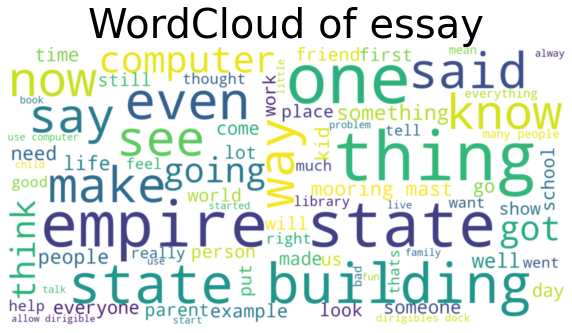

In [ ]:
word_cloud = WordCloud(
                       width=1600,
                       height=800, 
                       margin=0,
                       max_words=600, 
                       max_font_size=200, min_font_size=25,  
                       background_color="white"
            ).generate(" ".join(df_train['essay']))

plt.figure(figsize=(10, 16))
plt.imshow(word_cloud, interpolation="gaussian")
plt.title('WordCloud of essay', fontsize = 40)
plt.axis("off")
plt.show()

In [ ]:
df_test['essay'] = df_test['essay'].apply(lambda x: clean_text(x))

In [ ]:
df_test.head()

,essay_id,essay_set,essay,domain1_predictionid,domain2_predictionid
0,2383,1,i believe that computers have a positive effec...,2383,NaN
1,2384,1,dear i know some problems have came up where ...,2384,NaN
2,2385,1,dear to whom it concern computers arent the r...,2385,NaN
3,2386,1,dear has come to my attention that some peo...,2386,NaN
4,2387,1,dear local newspaper i think that people have ...,2387,NaN


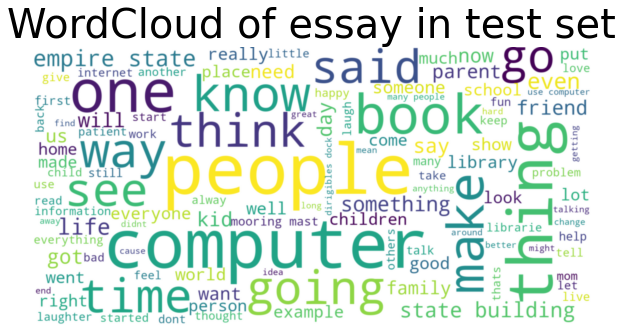

In [ ]:
word_cloud = WordCloud(
                       width=1600,
                       height=800, 
                       margin=0,
                       max_words=600, 
                       max_font_size=200, min_font_size=25,  
                       background_color="white"
            ).generate(" ".join(df_test['essay']))

plt.figure(figsize=(10, 16))
plt.imshow(word_cloud, interpolation="gaussian")
plt.title('WordCloud of essay in test set', fontsize = 40)
plt.axis("off")
plt.show()

## Tokenizing 

In [ ]:
##testing example
text = "Good evening! Let's eat now"

# instantiate tokenizer class
tokenizer1 = nltk.tokenize.WhitespaceTokenizer()
tokenizer2 = nltk.tokenize.TreebankWordTokenizer()
tokenizer3 = nltk.tokenize.WordPunctTokenizer()
tokenizer4 = nltk.tokenize.RegexpTokenizer(r'\w+')

print("Example Text: ", text)
print("Tokenization by whitespace: ", tokenizer1.tokenize(text))
print("Tokenization by words using Treebank Word Tokenizer: ", tokenizer2.tokenize(text))
print("Tokenization by punctuation: ", tokenizer3.tokenize(text))
print("Tokenization by regular expression: ", tokenizer4.tokenize(text))

Example Text:  Good evening! Let's eat now
Tokenization by whitespace:  ['Good', 'evening!', "Let's", 'eat', 'now']
Tokenization by words using Treebank Word Tokenizer:  ['Good', 'evening', '!', 'Let', "'s", 'eat', 'now']
Tokenization by punctuation:  ['Good', 'evening', '!', 'Let', "'", 's', 'eat', 'now']
Tokenization by regular expression:  ['Good', 'evening', 'Let', 's', 'eat', 'now']


In [ ]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

# Tokenizing the training set
df_train['essay'] = df_train['essay'].apply(lambda x: tokenizer.tokenize(x))

# Tokenizing the test set
df_test['essay'] = df_test['essay'].apply(lambda x: tokenizer.tokenize(x))

In [ ]:
print('Tokenized String:')
df_train['essay'].head()

Tokenized String:


0    [dear, local, newspaper, i, think, effects, co...
1    [dear, i, believe, that, using, computers, wil...
2    [dear, more, and, more, people, use, computers...
3    [dear, local, newspaper, i, have, found, that,...
4    [dear, i, know, having, computers, has, a, pos...
Name: essay, dtype: object

In [ ]:
print('Tokenized String:')
df_test['essay'].head()

Tokenized String:


0    [i, believe, that, computers, have, a, positiv...
1    [dear, i, know, some, problems, have, came, up...
2    [dear, to, whom, it, concern, computers, arent...
3    [dear, has, come, to, my, attention, that, som...
4    [dear, local, newspaper, i, think, that, peopl...
Name: essay, dtype: object

## Removing stopwords

In [ ]:
import nltk
nltk.download('stopwords')
def remove_stopwords(text):
    words = [word for word in text if word not in stopwords.words('english')]
    return words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df_train['essay'] = df_train['essay'].apply(lambda x: remove_stopwords(x))

In [ ]:
df_test['essay'] = df_test['essay'].apply(lambda x: remove_stopwords(x))

In [ ]:
df_train.head()

,essay_id,essay_set,essay,resolved_score
0,1,1,"[dear, local, newspaper, think, effects, compu...",8.0
1,2,1,"[dear, believe, using, computers, benefit, us,...",9.0
2,3,1,"[dear, people, use, computers, everyone, agree...",7.0
3,4,1,"[dear, local, newspaper, found, many, experts,...",10.0
4,5,1,"[dear, know, computers, positive, effect, peop...",8.0


In [ ]:
df_test.head()

,essay_id,essay_set,essay,domain1_predictionid,domain2_predictionid
0,2383,1,"[believe, computers, positive, effect, people,...",2383,NaN
1,2384,1,"[dear, know, problems, came, individuals, agre...",2384,NaN
2,2385,1,"[dear, concern, computers, arent, reason, peop...",2385,NaN
3,2386,1,"[dear, come, attention, people, believe, techn...",2386,NaN
4,2387,1,"[dear, local, newspaper, think, people, lately...",2387,NaN


In [ ]:
def combine_text(list_of_text):
    
    combined_text = ' '.join(list_of_text)
    return combined_text


In [ ]:
df_train['essay'] = df_train['essay'].apply(lambda x: combine_text(x))
df_train.head()

,essay_id,essay_set,essay,resolved_score
0,1,1,dear local newspaper think effects computers p...,8.0
1,2,1,dear believe using computers benefit us many w...,9.0
2,3,1,dear people use computers everyone agrees bene...,7.0
3,4,1,dear local newspaper found many experts say co...,10.0
4,5,1,dear know computers positive effect people com...,8.0


In [ ]:
df_test['essay'] = df_test['essay'].apply(lambda x: combine_text(x))
df_test.head()

,essay_id,essay_set,essay,domain1_predictionid,domain2_predictionid
0,2383,1,believe computers positive effect people help ...,2383,NaN
1,2384,1,dear know problems came individuals agree bene...,2384,NaN
2,2385,1,dear concern computers arent reason people don...,2385,NaN
3,2386,1,dear come attention people believe technology ...,2386,NaN
4,2387,1,dear local newspaper think people lately spent...,2387,NaN


In [ ]:
def text_preprocessing(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [word for word in tokenized_text if word not in stopwords.words('english')]
    ##combined_text = ' '.join(remove_stopwords)
    return combined_text

# Feature Extraction

In [ ]:
from collections import Counter
nltk.download('averaged_perceptron_tagger')
  

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
def preprocess_data2feature(X,target_col):
    # Generate feature columns for 15 custom features and a target value column    
    feature_columns = ["essay","word_count","long_word_count","avg_word_length_per_essay","noun_count","verb_count","adjective_count","adverb_count"]
    feature_pd = pd.DataFrame(index = X.index, columns = feature_columns)
    feature_pd['essay'] = X['essay']
    feature_pd['target'] = X[target_col]
    
    return feature_pd

In [ ]:
def featureSet2(X): 
    # Extract features from the given essay and assign the value/count to the respective column.
    for index,row in X.iterrows():
        text = row['essay']
        
        #word_count
        word_count = len(text)
        row['word_count'] = word_count
        
        #Long word count
        long_word_count = 0
        total_word_length = 0
        for word in text:
            total_word_length += len(word)
            if len(word) > 6:
                long_word_count +=1
        row['long_word_count'] = long_word_count
        
        #Average word length per essay
        row['avg_word_length_per_essay'] = round((total_word_length/float(len(text))),2)
        
        #POS TAGS
        count= Counter([j for i,j in nltk.pos_tag(text)])       
        row['noun_count'] = count['NN'] + count['NNS'] + count['NNPS'] + count['NNP']
        row['verb_count'] = count['VB'] + count['VBG'] + count['VBP'] + count['VBN'] + count['VBZ']
        row['adjective_count'] = count['JJ'] + count['JJR'] 
        row['adverb_count'] = count['RB'] + count['RBR'] + count['RBS']
            

In [ ]:
def GenerateFeatures(X):
    #start = time()
    featureSet2(X)

In [ ]:
feature_data = preprocess_data2feature(df_train,'resolved_score')
feature_data.head()

,essay,word_count,long_word_count,avg_word_length_per_essay,noun_count,verb_count,adjective_count,adverb_count,target
0,dear local newspaper think effects computers p...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
1,dear believe using computers benefit us many w...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0
2,dear people use computers everyone agrees bene...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
3,dear local newspaper found many experts say co...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0
4,dear know computers positive effect people com...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0


In [ ]:
feature_cols = list(feature_data.columns[:-1])
X_all = feature_data[feature_cols]
y_all = feature_data['target']

In [ ]:
#Generate the feature set.
print(len(X_all))
GenerateFeatures(X_all[:50])
GenerateFeatures(X_all[50:100])
GenerateFeatures(X_all[100:900])
GenerateFeatures(X_all[900:1700])
GenerateFeatures(X_all[1700:2500])
GenerateFeatures(X_all[2500:3300])
GenerateFeatures(X_all[3300:4100])
GenerateFeatures(X_all[4100:4900])
GenerateFeatures(X_all[4900:])

12976


In [ ]:
X_all = feature_data.drop(['target'], axis=1)

In [ ]:
X_all[4000:4020]

,essay,word_count,long_word_count,avg_word_length_per_essay,noun_count,verb_count,adjective_count,adverb_count
4000,cyclist first recieves directions yosemite par...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4001,essay rough road ahead exceed posted speed lim...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4002,story cyclist affect many features desert main...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4003,essay setting affects cyclist different ways e...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4004,terrain described essay add affect strugles cy...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4005,essay cyclist riding desert extremely hot june...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4006,features setting negatively affect cyclist cyc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4007,think explains good job good either right thin...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4008,essay rough road ahead posted speed limit joe ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4009,features affect cyclist big way one heat beati...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
y_all[:5]

0     8.0
1     9.0
2     7.0
3    10.0
4     8.0
Name: target, dtype: float64

## Vectorization

In [ ]:
x_np = X_all.to_numpy()
y_np = y_all.to_numpy()

In [ ]:
X_cv = x_np
y_cv = y_np

X_train, X_test, y_train, y_test = train_test_split(X_cv, y_cv, test_size = 0.3)

In [ ]:
type(x_np)

numpy.ndarray

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [ ]:
# Instantiate dt_entropy, set 'entropy' as the information criterion
dt_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=1)

# Fit dt_entropy to the training set
dt_entropy.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_entropy.predict(X_test)

# Evaluate accuracy_entropy
accuracy_entropy = accuracy_score(y_pred, y_test)
accuracy_entropy


ValueError: ignored

In [ ]:
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(df_train['essay'])
test_vectors = count_vectorizer.transform(df_test['essay'])

In [ ]:
print(train_vectors[0].todense())  ##keeping non-zero elements to preserve spaces

In [ ]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2)) 
##Transforms text to feature vectors that can be used as input to estimator.

train_tfidf = tfidf.fit_transform(df_train['essay'])
test_tfidf = tfidf.transform(df_test['essay'])

In [ ]:
classifiers = {
    "LogisticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(n_neighbors=1),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "MultinimialNB": MultinomialNB()
}

In [ ]:
from sklearn.model_selection import cross_val_score

# Classifier Models

In [ ]:
# Implementing the kNearestNeighbors Model

classifierKNN = KNeighborsClassifier()
#classifierKNN = KNeighborsClassifier(n_neighbors=1)

classifierKNN.fit(train_vectors, df_train["domain1_score"])
training_scoreKNN = cross_val_score(classifierKNN, train_vectors, df_train["domain1_score"], cv=5)
print("Classifiers: ", classifierKNN.__class__.__name__, "Has a training score of", round(training_scoreKNN.mean(), 2) * 100, "% accuracy score")

In [ ]:
# Implementing the logisticRegression Model

classifierLogisticRegression = LogisticRegression()

classifierLogisticRegression.fit(train_vectors, df_train["domain1_score"])
training_scoreLogisticRegression = cross_val_score(classifierLogisticRegression, train_vectors, df_train["domain1_score"], cv=5)
print("Classifiers: ", classifierLogisticRegression.__class__.__name__, "Has a training score of", round(training_scoreLogisticRegression.mean(), 2) * 100, "% accuracy score")

In [ ]:
# Implementing the supportVectorClassifier Model

classifierSVC = SVC()

classifierSVC.fit(train_vectors, df_train["domain1_score"])
training_scoreSVC = cross_val_score(classifierSVC, train_vectors, df_train["domain1_score"], cv=5)
print("Classifiers: ", classifierSVC.__class__.__name__, "Has a training score of", round(training_scoreSVC.mean(), 2) * 100, "% accuracy score")

In [ ]:
# Implementing the decisionTreeClassifier Model

classifierDecisionTree = DecisionTreeClassifier()

classifierDecisionTree.fit(train_vectors, df_train["domain1_score"])
training_scoreDecisionTreeClassifier = cross_val_score(classifierDecisionTree, train_vectors, df_train["domain1_score"], cv=5)
print("Classifiers: ", classifierDecisionTree.__class__.__name__, "Has a training score of", round(training_scoreDecisionTreeClassifier.mean(), 2) * 100, "% accuracy score")

In [ ]:
# Implementing the multinomialNB Model

classifierMultinomialNB = MultinomialNB()

classifierMultinomialNB.fit(train_vectors, df_train["domain1_score"])
training_scoreMultinomialNB = cross_val_score(classifierMultinomialNB, train_vectors, df_train["domain1_score"], cv=5)
print("Classifiers: ", classifierMultinomialNB.__class__.__name__, "Has a training score of", round(training_scoreMultinomialNB.mean(), 2) * 100, "% accuracy score")

#Visualization